# LSTM Model for Vehicle Collisions

## Import Required Libraries

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

## Create New Features

In [2]:
def min_distance_to_ego(frame_df, image_width = 1280, image_height = 720):
    ego_x, ego_y = image_width / 2, (image_height - 90)
    centers_x = (frame_df["x_min"] + frame_df["x_max"]) / 2
    centers_y = (frame_df["y_min"] + frame_df["y_max"]) / 2
    distances = np.sqrt((centers_x - ego_x) ** 2 + (centers_y - ego_y) ** 2)

    return distances.min() if not distances.empty else 0.0



def max_box_area_growth(current_df, prev_df = None):
    current_areas = (current_df["x_max"] - current_df["x_min"]) * (current_df["y_max"] - current_df["y_min"])

    if prev_df is None or prev_df.empty:
        return 0.0
    
    prev_areas = (prev_df["x_max"] - prev_df["x_min"]) * (prev_df["y_max"] - prev_df["y_min"])
    
    # Ensure the prev_areas is properly handled
    if not prev_areas.empty:
        return (current_areas.max() - prev_areas.max())
    return 0.0

def max_box_area(current_df):
    box_areas = (current_df["x_max"] - current_df["x_min"]) * (current_df["y_max"] - current_df["y_min"])

    return box_areas.max()


def delta_x_center_near_objects(current_df, prev_df = None, threshold_y_ratio = 0.75, image_height = 720):
    if prev_df is None:
        return 0.0

    current_close = current_df[(current_df["y_max"]) > image_height * threshold_y_ratio]
    prev_close = prev_df[(prev_df["y_max"]) > image_height * threshold_y_ratio]

    def avg_x(df):
        return ((df["x_min"] + df["x_max"]) / 2).mean() if not df.empty else 0.0

    return avg_x(current_close) - avg_x(prev_close)

# Count of large, low-positioned objects (danger zone)
def num_objects_in_danger_zone(frame_df, image_width = 1280, image_height = 720, y_threshold = 0.85, area_threshold = 10000):
    danger_zone_y_min = image_height - 90

    danger_zone_objects = frame_df[
        (frame_df["y_max"] > danger_zone_y_min * y_threshold) &
        ((frame_df["x_max"] - frame_df["x_min"]) * (frame_df["y_max"] - frame_df["y_min"]) > area_threshold)
    ]
    return len(danger_zone_objects)

def max_vertical_shift(current_df, prev_df):
    if prev_df is None or prev_df.empty or current_df.empty:
        return 0.0
    
    current_y = ((current_df["y_min"] + current_df["y_max"]) / 2)
    prev_y = ((prev_df["y_min"] + prev_df["y_max"]) / 2)
    
    return (current_y.mean() - prev_y.mean()) if not current_df.empty and not prev_df.empty else 0.0

## Extract Features from Each Frame

In [3]:
def extract_frame_features(frame_df, prev_frame_df = None):
    relevant_classes = [2, 5, 7]
    frame_df = frame_df[frame_df["object_class"].isin(relevant_classes)]

    # Early exit if frame_df is empty
    if frame_df.empty:
        # Return an X-dimensional zero tensor if no objects are detected
        return torch.zeros(5)  

    features = []

    num_objects = len(frame_df)
    avg_conf = frame_df["confidence"].mean()
    avg_box_area = ((frame_df["x_max"] - frame_df["x_min"]) * (frame_df["y_max"] - frame_df["y_min"])).mean()

    # Number of desired object classes
    desired_size = 13
    class_counts = np.zeros(desired_size)

    # Count the occurrence of each class in the frame
    for cls in frame_df["object_class"]:
        cls = int(cls)
        if cls < desired_size:
            class_counts[cls] += 1

    # Individual class counts
    car_count = (frame_df["object_class"] == 2).sum()
    bus_count = (frame_df["object_class"] == 7).sum()
    truck_count = (frame_df["object_class"] == 5).sum()

    # New calculated features
    min_dist = min_distance_to_ego(frame_df)
    box_growth = max_box_area_growth(frame_df, prev_frame_df)
    largest_box_area = max_box_area(frame_df)
    lateral_shift = delta_x_center_near_objects(frame_df, prev_frame_df)
    num_danger_objects = num_objects_in_danger_zone(frame_df)
    largest_vertical_shift = max_vertical_shift(frame_df, prev_frame_df)

    # Combine into one feature tensor
    #raw_features = torch.tensor([num_objects, avg_conf, avg_box_area, min_dist, box_growth, lateral_shift] + class_counts.tolist(), dtype = torch.float32)
    raw_features = torch.tensor([avg_box_area, min_dist, largest_box_area, box_growth, num_danger_objects], dtype = torch.float32)

    return raw_features

## Process Feature and Add Delta Features

In [ ]:
def process_video_csv(csv_path, scaler = None):
    df = pd.read_csv(csv_path)

    # Return empty tensor if the df is empty or missing the frame column
    if df.empty or "frame" not in df.columns:
        return torch.empty(0, 7)  

    sequences = []
    prev_features = None
    prev_frame_df = None
    no_delta_indices = [2, 3, 4]

    for _, frame_df in df.groupby("frame"):
        current_features = extract_frame_features(frame_df, prev_frame_df)

        if isinstance(current_features, np.ndarray):
            current_features = torch.tensor(current_features, dtype = torch.float32)

        # If there are previous features, compute the delta
        if prev_features is None:
            delta_features = torch.zeros_like(current_features)
            delta_features = delta_features[:-len(no_delta_indices)]
        else:
            # Indices to include in the delta calculation
            included_delta_indices = [i for i in range(len(current_features)) if i not in no_delta_indices]

            # Only compute deltas for the included indices
            delta_features = (current_features - prev_features)[included_delta_indices]

        # Concatenate raw features and delta features
        full_features = torch.cat([current_features, delta_features])

        # Scale features if scaler is provided
        if scaler:
            full_features = torch.tensor(scaler.transform([full_features.numpy()])[0], dtype = torch.float32)

        sequences.append(full_features)

        # Update prev_features and prev_frame_df for the next frame
        prev_features = current_features

        # Store the current frame_df for next iteration
        prev_frame_df = frame_df  

    # If no sequences, return empty tensor
    if not sequences:
        return torch.empty(0, 7)

    # Stack all sequences into a single tensor
    sequences = torch.stack(sequences)

    return sequences

## Load True Data Labels

In [5]:
import csv

# Load label CSV into a dictionary
label_dict = {}
with open("../../data/train_labels.csv", newline = "") as f:
    reader = csv.DictReader(f)
    for row in reader:
        label_dict[row["id"]] = int(row["target"])

## Split Data into Training, Validation, and Test Sets

In [6]:
from sklearn.model_selection import train_test_split

# Get all video directories
video_dirs = sorted([
    os.path.join("../data/yolo_processed_data", d)
    for d in os.listdir("../../data/yolo_processed_data")
    if os.path.isdir(os.path.join("../../data/yolo_processed_data", d))
])

# Initialize an empty list to store video_ids
video_ids = []

# Extract video IDs from the directory names, removing video_ prefix
for video_dir in video_dirs:
    video_id = os.path.basename(video_dir).replace("video_", "")
    video_ids.append(video_id)

# Ensure there are labels for all video IDs
for video_id in video_ids:
    if video_id not in label_dict:
        raise AssertionError(f"Label missing for video: {video_id}")
    

valid_video_ids = []
invalid_count = 0

for video_id in video_ids:
    video_dir = os.path.join("../../data/yolo_processed_data", "video_" + video_id)
    detections_csv = os.path.join(video_dir, "detections.csv")

    try:
        df = pd.read_csv(detections_csv)
        if (not df.empty and "frame" in df.columns and df["frame"].nunique() > 0 and len(df) >= 13):
            valid_video_ids.append(video_id)
        else:
            invalid_count += 1
    except:
        invalid_count += 1

print(f"Count of Videos With Invalid Detections: {invalid_count}")

# Split the video IDs
train_ids, temp_ids = train_test_split(valid_video_ids, test_size = 0.2)
val_ids, test_ids = train_test_split(temp_ids, test_size = 0.5)


# Initialize empty lists to store the video directories
train_videos = []
val_videos = []
test_videos = []

# Populate the train_videos list with the corresponding directories
for video_id in train_ids:
    video_dir = os.path.join("../../data/yolo_processed_data", "video_" + video_id)
    train_videos.append(video_dir)

# Populate the val_videos list with the corresponding directories
for video_id in val_ids:
    video_dir = os.path.join("../../data/yolo_processed_data", "video_" + video_id)
    val_videos.append(video_dir)


# Populate the test_videos list with the corresponding directories
for video_id in test_ids:
    video_dir = os.path.join("../../data/yolo_processed_data", "video_" + video_id)
    test_videos.append(video_dir)


Count of Videos With Invalid Detections: 76


In [7]:
# Shape Sanity Check
print(f"-----Dataset Sizes-----")
print(f"Total Video Count: {len(valid_video_ids)}")
print(f"Train Videos       - {len(train_videos)} Videos | {(len(train_videos) / len(valid_video_ids)) * 100}%")
print(f"Validation Videos  - {len(val_videos)} Videos | {(len(val_videos) / len(valid_video_ids)) * 100}%")
print(f"Test Videos        - {len(test_videos)} Videos | {(len(test_videos) / len(valid_video_ids)) * 100}%")


print(f"\n-----Sample Dataset Values-----")
print(f"Train Videos       - {train_videos[0:2]}")
print(f"Validation Videos  - {val_videos[0:2]}")
print(f"Test Videos        - {test_videos[0:2]}")

# Count labels in each set
def count_labels(video_ids, label_dict):
    counts = {0: 0, 1: 0}
    for video in video_ids:
        counts[label_dict[video]] += 1
    return counts

# Count and print for each set
train_counts = count_labels(train_ids, label_dict)
val_counts = count_labels(val_ids, label_dict)
test_counts = count_labels(test_ids, label_dict)


print(f"\n-----Label Counts Per Set-----")
print("Train Set - No Collision:", train_counts[0], "| Collision:", train_counts[1])
print("Val Set   - No Collision:", val_counts[0],   "| Collision:", val_counts[1])
print("Test Set  - No Collision:", test_counts[0],  "| Collision:", test_counts[1])

-----Dataset Sizes-----
Total Video Count: 1424
Train Videos       - 1139 Videos | 79.98595505617978%
Validation Videos  - 142 Videos | 9.97191011235955%
Test Videos        - 143 Videos | 10.042134831460674%

-----Sample Dataset Values-----
Train Videos       - ['../../data/yolo_processed_data\\video_01699', '../../data/yolo_processed_data\\video_01609']
Validation Videos  - ['../../data/yolo_processed_data\\video_00235', '../../data/yolo_processed_data\\video_01078']
Test Videos        - ['../../data/yolo_processed_data\\video_01319', '../../data/yolo_processed_data\\video_00440']

-----Label Counts Per Set-----
Train Set - No Collision: 538 | Collision: 601
Val Set   - No Collision: 80 | Collision: 62
Test Set  - No Collision: 73 | Collision: 70


In [8]:
feature_scaler = StandardScaler()

all_train_features = []
no_delta_indices = [2, 3, 4]

for video_dir in train_videos:
    csv_path = os.path.join(video_dir, "detections.csv")
    df = pd.read_csv(csv_path)

    prev_features = None
    prev_frame_df = None

    for _, frame_df in df.groupby("frame"):
        raw_features = extract_frame_features(frame_df, prev_frame_df)
        
        # Conmbine raw features and delta features
        if prev_features is None:
            delta_features = torch.zeros_like(raw_features)
            delta_features = delta_features[:-len(no_delta_indices)]
        else:
            # Indices to include in the delta calculation
            included_indices = [i for i in range(len(raw_features)) if i not in no_delta_indices]

            # Only compute deltas for the included indices
            delta_features = (raw_features - prev_features)[included_indices]

        full_features = torch.cat([raw_features, delta_features])
        
        # Ensure all full_feat is X-dimensional
        all_train_features.append(full_features.numpy())
        
        prev_features = raw_features
        prev_frame_df = frame_df 

all_train_features = np.array(all_train_features)

# Fit the scaler
feature_scaler.fit(all_train_features)

StandardScaler()

In [9]:
# Sanity Check for Feature Shape
print(all_train_features.shape)


#S Sanity check for Feature Values
column_names = ["avg_box_area", "min_dist", "largest_box_area", "largest_box_growth", "num_danger_objects",
                "delta_avg_box_area", "delta_min_dist"]

print(f"\n-----Example Frame 0 (Video {train_videos[0]})-----")
row = all_train_features[0]
for name, val in zip(column_names, row):
    print(f"{name}: {val:.2f}")

print(f"\n-----Example Frame 1 (Video {train_videos[0]})-----")
row = all_train_features[1]
for name, val in zip(column_names, row):
    print(f"{name}: {val:.2f}")

input_size = all_train_features.shape[1]

(41068, 7)

-----Example Frame 0 (Video ../../data/yolo_processed_data\video_01699)-----
avg_box_area: 39840.78
min_dist: 435.09
largest_box_area: 100803.73
largest_box_growth: 0.00
num_danger_objects: 0.00
delta_avg_box_area: 0.00
delta_min_dist: 0.00

-----Example Frame 1 (Video ../../data/yolo_processed_data\video_01699)-----
avg_box_area: 34499.61
min_dist: 456.35
largest_box_area: 65425.95
largest_box_growth: -35377.78
num_danger_objects: 0.00
delta_avg_box_area: -5341.18
delta_min_dist: 21.25


avg_box_area: 0.1527
min_dist: 0.1292
largest_box_area: 0.1424
largest_box_growth: 0.1380
num_danger_objects: 0.1547
delta_avg_box_area: 0.1409
delta_min_dist: 0.1422
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       538
           1       1.00      1.00      1.00       601

    accuracy                           1.00      1139
   macro avg       1.00      1.00      1.00      1139
weighted avg       1.00      1.00      1.00      1139



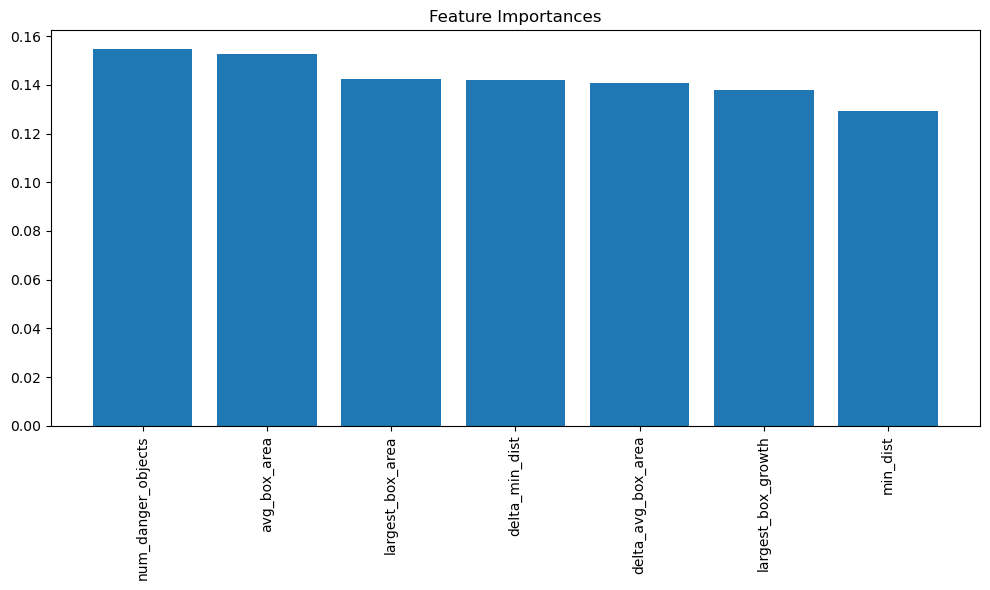

In [10]:
video_features = []
video_labels = []

frame_counts = {video: 0 for video in train_videos}
video_feature_buffer = {video: [] for video in train_videos}

i = 0
for video_dir in train_videos:
    csv_path = os.path.join(video_dir, "detections.csv")
    df = pd.read_csv(csv_path)
    num_frames = df["frame"].nunique()
    
    # Extract the right chunk of frames
    video_feats = all_train_features[i : i + num_frames]
    i += num_frames

    # Aggregate frame features to video-level features
    mean_feats = np.mean(video_feats, axis=0)
    video_features.append(mean_feats)

    # Get label
    video_id = os.path.basename(video_dir).replace("video_", "")
    label = label_dict[video_id]
    video_labels.append(label)

video_features = np.array(video_features)
video_labels = np.array(video_labels)


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
clf.fit(video_features, video_labels)

# Get feature importances
importances = clf.feature_importances_
for name, imp in zip(column_names, importances):
    print(f"{name}: {imp:.4f}")

# Print classification report
preds = clf.predict(video_features)
print(classification_report(video_labels, preds))

import matplotlib.pyplot as plt

sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize = (10, 6))
plt.bar(range(len(importances)), importances[sorted_idx], tick_label = np.array(column_names)[sorted_idx])
plt.xticks(rotation = 90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

## Create Dataset and DataLoader

In [11]:
# Create a dataset class for the video sequences
class VideoDataset(Dataset):
    def __init__(self, video_dirs, label_dict, scaler = None):
        self.video_dirs = video_dirs
        self.label_dict = label_dict
        self.scaler = scaler

    def __len__(self):
        return len(self.video_dirs)
    
    def __getitem__(self, idx):
        while True:
            video_dir = self.video_dirs[idx]
            video_id = os.path.basename(video_dir)
            
            if video_id.startswith("video_"):
                video_id = video_id.replace("video_", "")

            video_id = video_id.zfill(5)

            label = self.label_dict.get(video_id, 0)

            csv_path = os.path.join(video_dir, "detections.csv")
            seq = process_video_csv(csv_path, scaler = self.scaler)

            if seq is None:
                idx = (idx + 1) % len(self.video_dirs)
                return self.__getitem__(idx)

            return seq, torch.tensor(label, dtype = torch.float32)
    
    
# Collate function to pad sequences and create batches
def collate_fn(batch):

    # Filter out samples with empty sequences
    batch = [(x, y) for x, y in batch if x.size(0) > 0]

    if len(batch) == 0:
        return None

    batch.sort(key = lambda x: x[0].size(0), reverse = True)

    sequences, labels = zip(*batch)

    # Get the sequence lengths
    lengths = torch.tensor([len(seq) for seq in sequences])

    # Pad sequences with zero padding
    padded_seqs = pad_sequence(sequences, batch_first = True, padding_value = 0)  
    labels = torch.stack(labels)
    
    return padded_seqs, lengths, labels

# Create datasets for training, validation, and testing
train_dataset = VideoDataset(train_videos, label_dict, scaler = feature_scaler)
val_dataset = VideoDataset(val_videos, label_dict, scaler = feature_scaler)
test_dataset = VideoDataset(test_videos, label_dict, scaler = feature_scaler)

# Create DataLoader objects for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size = 4, shuffle = False, collate_fn = collate_fn)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle = False, collate_fn = collate_fn)

## Define the LSTM Model

In [13]:
# Define the LSTM model for classification  
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1

        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout if num_layers > 1 else 0.0,
            batch_first = True,
            bidirectional = self.bidirectional
        )

        self.fc = nn.Linear(hidden_size * self.num_directions, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first = True, enforce_sorted = False)
        packed_output, (hn, cn) = self.lstm(packed)

        hn = hn.view(self.num_layers, self.num_directions, x.size(0), self.hidden_size)

        if self.bidirectional:
            last_layer_forward = hn[-1, 0]
            last_layer_backward = hn[-1, 1]
            final_hidden = torch.cat([last_layer_forward, last_layer_backward], dim = 1)
        else:
            final_hidden = hn[-1, 0]

        out = self.fc(final_hidden)
        out = self.sigmoid(out)

        return out.squeeze()

## Training Loop

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, device, epochs, print_epochs = False):
    model.to(device)

    # Initialize a previous loss value as a variable to compare validation losses to after each iteration
    previous_val_loss = float("inf")

    # Initialize loss lists and early stopping epochs
    train_losses = []
    val_losses = []
    early_stopping_epochs = 0

    # Iterate through epochs
    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_train_loss = 0

        for batch in train_loader:
            if batch is None:
                continue

            x_batch, lengths, y_batch = batch   
            x_batch, lengths, y_batch = x_batch.to(device), lengths.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch, lengths)

            # Ensure that y_batch is in float format
            y_batch = y_batch.float()

            # Ensure outputs are in the correct range [0, 1]
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        running_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                if batch is None:
                    continue

                x_val, val_lengths, y_val = batch
                x_val, val_lengths, y_val = x_val.to(device), val_lengths.to(device), y_val.to(device)

                val_outputs = model(x_val, val_lengths)
                val_outputs = val_outputs.view(-1)

                # Ensure y_val is in float format
                y_val = y_val.view(-1)

                val_loss = criterion(val_outputs, y_val)
                running_val_loss += val_loss.item()

                preds = (val_outputs > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate accuracy
        val_accuracy = accuracy_score(all_labels, all_preds)

        if print_epochs:
            print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val Accuracy = {val_accuracy:.4f}")

        # Early stop if validation loss change is below tolerance
        if previous_val_loss > avg_val_loss:
            previous_val_loss = avg_val_loss
            early_stopping_epochs = 0
        else:
            early_stopping_epochs += 1

        # Break the loop if early stopping criteria is met
        if early_stopping_epochs >= patience:
            #print("Early stopping triggered.")
            break

    return train_losses, val_losses



## Tune Hyperparameters

In [15]:
# Function to iterate through differnt combinations of hyperparameters
def tune_lstm_hyperparameters(train_loader, val_loader, params, input_size, epochs, patience):
    best_params = None
    best_val_loss = float("inf")
    results = []

    # Calculate total combinations
    total_combinations = (
        len(params["hidden_size"]) *
        len(params["num_layers"]) *
        len(params["dropout"]) *
        len(params["learning_rate"]) *
        len(params["optimizer"])
    )

    with tqdm(total = total_combinations, desc = "Tuning") as progressbar:
        for hidden_size in tqdm(params["hidden_size"]):
            for dropout in params["dropout"]:
                for learning_rate in params["learning_rate"]:
                    for num_layers in params["num_layers"]:
                        for optimizer_name in params["optimizer"]:
                            
                            # Initialize the LSTM model with the current parameter combinations
                            model = LSTMClassifier(input_size = input_size,
                                                hidden_size = hidden_size,
                                                num_layers = num_layers,
                                                dropout = dropout)
                            
                            # Select the appropriate optimizer
                            if optimizer_name == "adam":
                                optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
                            elif optimizer_name == "rmsprop":
                                optimizer = optim.RMSprop(model.parameters(), lr = learning_rate)
                            else:
                                continue
                            
                            # Define loss function
                            criterion = nn.BCELoss()
                            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                            
                            # Train the model
                            train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, patience, device, epochs)
                            final_val_loss = val_losses[-1] if val_losses else float("inf")


                            # Append results of the run to the dictionary
                            results.append({
                                "hidden_size": hidden_size,
                                "dropout": dropout,
                                "learning_rate": learning_rate,
                                "num_layers": num_layers,
                                "optimizer": optimizer_name,
                                "final_val_loss": final_val_loss
                            })


                            # Store the current parameters if they produce a lower val loss than the previous best
                            if final_val_loss < best_val_loss:
                                best_val_loss = final_val_loss
                                best_params = {
                                    "hidden_size": hidden_size,
                                    "dropout": dropout,
                                    "learning_rate": learning_rate,
                                    "num_layers": num_layers,
                                    "optimizer": optimizer_name
                                }


                            # Update progress bar
                            progressbar.update(1)

    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Validation Loss: {best_val_loss:.2f}")
    
    return best_params, results


In [216]:
"""
params = {
    "hidden_size": [64, 128, 256],
    "dropout": [0.3, 0.4],
    "learning_rate": [0.001, 0.0001],
    "num_layers": [1, 2, 3],
    "optimizer": ["adam", "rmsprop"]
}
"""

params = {
    "hidden_size": [128, 256],
    "dropout": [0.2],
    "learning_rate": [0.001, 0.001],
    "num_layers": [3, 4],
    "optimizer": ["adam"]
}

input_size = input_size
epochs = 10
patience = 3

best_params, results = tune_lstm_hyperparameters(train_loader, val_loader, params, input_size, epochs, patience)

Tuning: 100%|██████████| 8/8 [4:59:17<00:00, 2244.66s/it]

Best Hyperparameters: {'hidden_size': 128, 'dropout': 0.2, 'learning_rate': 0.001, 'num_layers': 3, 'optimizer': 'adam'}
Best Validation Loss: 0.6631194857756296


## Plot the Training and Validation Loss Curves for the Optimal Model

Epoch 1: Train Loss = 0.6930 | Val Loss = 0.6754 | Val Accuracy = 0.5634
Epoch 2: Train Loss = 0.6783 | Val Loss = 0.6914 | Val Accuracy = 0.5775
Epoch 3: Train Loss = 0.6784 | Val Loss = 0.6717 | Val Accuracy = 0.5986
Epoch 4: Train Loss = 0.6754 | Val Loss = 0.6692 | Val Accuracy = 0.6338
Epoch 5: Train Loss = 0.6870 | Val Loss = 0.6861 | Val Accuracy = 0.5845
Epoch 6: Train Loss = 0.6700 | Val Loss = 0.7080 | Val Accuracy = 0.4366
Epoch 7: Train Loss = 0.6681 | Val Loss = 0.6750 | Val Accuracy = 0.6056
Epoch 8: Train Loss = 0.6658 | Val Loss = 0.6826 | Val Accuracy = 0.5845
Epoch 9: Train Loss = 0.6666 | Val Loss = 0.6700 | Val Accuracy = 0.6127


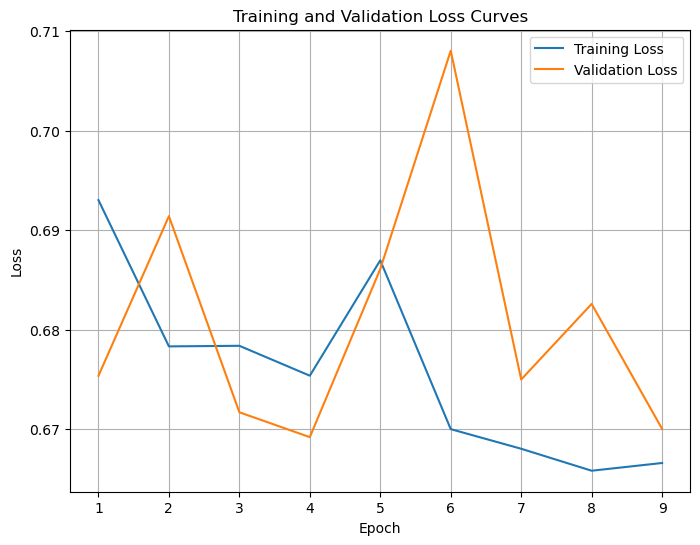

In [16]:
input_size = input_size

best_params = {
    "hidden_size": 128,
    "dropout": 0.2,
    "learning_rate": 0.001,
    "num_layers": 3,
    "optimizer": "adam"
}


# Intialize the model with the tuned optimal parameters
model = LSTMClassifier(input_size = input_size, hidden_size = best_params["hidden_size"], num_layers = best_params["num_layers"], dropout = best_params["dropout"])


# Identify the optimal optimizer
if best_params["optimizer"] == "adam":
    optimizer = optim.Adam(model.parameters(), lr = best_params["learning_rate"], weight_decay = 1e-5)
    
elif best_params["optimizer"] == "rmsprop":
    optimizer = optim.RMSprop(model.parameters(), lr = best_params["learning_rate"])


# Determine number of epochs, level of patience, whether to print epoch outputs, loss function, and device
epochs = 100
patience = 5
print_epochs = True
criterion = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the optimal model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, patience, device, epochs, print_epochs)


# Plot training and validation losses after all epochs are finished
plt.figure(figsize = (8, 6))
sns.lineplot(x = range(1, len(train_losses) + 1), y = train_losses, label = "Training Loss")
sns.lineplot(x = range(1, len(val_losses) + 1), y = val_losses, label = "Validation Loss")
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

## Save Model

In [ ]:
#torch.save(model.state_dict(), "./best_lstm_model.pth")

## Evaluate the Test Set

In [17]:
def evaluate_model(model, test_loader, device, criterion):
    model.eval()

    total_test_loss = 0.0
    all_preds = []
    all_labels = []
    all_outputs = [] 

    with torch.no_grad():
        for x_batch, lengths, y_batch in test_loader:
            x_batch, lengths = x_batch.to(device), lengths.to(device)

            outputs = model(x_batch, lengths).squeeze()
            y_batch = y_batch.float().squeeze()               

            # Make sure both are 1D tensors
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            if y_batch.dim() == 0:
                y_batch = y_batch.unsqueeze(0)


                
            test_loss = criterion(outputs, y_batch)
            total_test_loss += test_loss.item() * x_batch.size(0)

            # Convert probabilities to binary predictions (0 or 1) based on threshold of 0.5
            preds = (outputs > 0.5).float()

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

        # Calculate test loss
        avg_test_loss = (total_test_loss) / (len(test_loader.dataset))
        print(f"Test Loss: {avg_test_loss:.4f}")

        # Calculate test accuracy
        test_accuracy = accuracy_score(all_labels, all_preds)
        print(f"Test Accuracy: {test_accuracy:.4f}")


    return np.array(all_preds), np.array(all_labels), np.array(all_outputs)



criterion = nn.BCELoss()

y_pred, y_true, y_scores = evaluate_model(model, test_loader, device, criterion)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

Test Loss: 0.6543
Test Accuracy: 0.6573


In [18]:
# Log predictions
test_results = pd.DataFrame({
    "actual": y_true,
    "prediction": y_pred,
})

print(f"Model Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}\n")

print(classification_report(y_true, y_pred, digits = 4))

test_results.head(10)

Model Metrics:
Accuracy: 0.6573
Precision: 0.7059
Recall: 0.5143
F1 Score: 0.5950

              precision    recall  f1-score   support

         0.0     0.6304    0.7945    0.7030        73
         1.0     0.7059    0.5143    0.5950        70

    accuracy                         0.6573       143
   macro avg     0.6682    0.6544    0.6490       143
weighted avg     0.6674    0.6573    0.6502       143



,actual,prediction
0,0.0,0.0
1,0.0,1.0
2,1.0,1.0
3,0.0,0.0
4,1.0,1.0
5,1.0,0.0
6,1.0,1.0
7,1.0,0.0
8,0.0,0.0
9,0.0,0.0


## Confusion Matrix

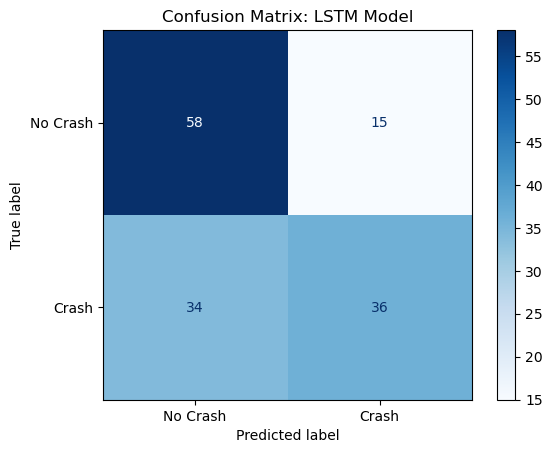

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Crash", "Crash"])
disp.plot(cmap = "Blues", values_format = "d")
plt.title("Confusion Matrix: LSTM Model")
#
plt.show()

## ROC Curve

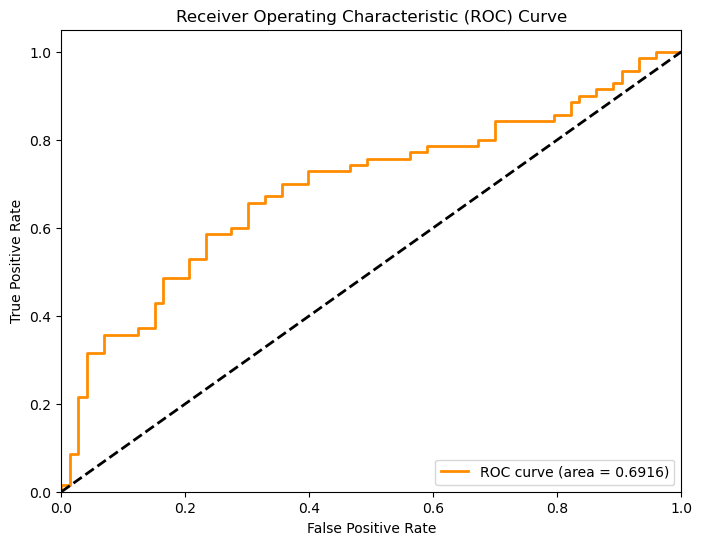

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcualte ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Plot ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color = "black", lw = 2, linestyle = "--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc = "lower right")
#plt.savefig("ROC_lstm.png", dpi = 300, bbox_inches = "tight")
plt.show()